In [9]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D,Dropout,Flatten,MaxPooling2D,Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tqdm.notebook import tqdm 
import warnings 

warnings.filterwarnings('ignore')
%matplotlib inline

In [10]:
BASE_DIR = '/Users/harjeetchahal/Downloads/archive (2)/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

In [11]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [1]:
print(age_labels[:10])
print(gender_labels[:10])
print(image_paths[:10])

NameError: name 'age_labels' is not defined

In [13]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [14]:
print(gender_labels[:10])

[0, 0, 0, 0, 0, 0, 1, 1, 0, 1]


21
0


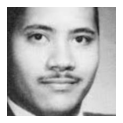

29
0


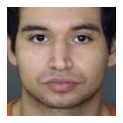

35
0


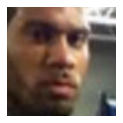

74
0


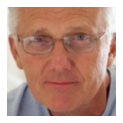

45
0


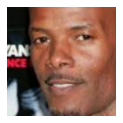

58
0


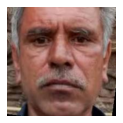

15
1


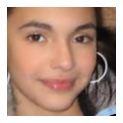

31
1


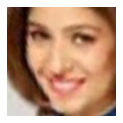

40
0


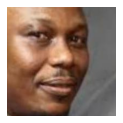

43
1


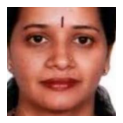

In [15]:
import cv2
import matplotlib.pyplot as plt

# Load and display the first 10 images
for i in range(10):
    image_path = image_paths[i]
    image = cv2.imread(image_path)

    # Display the image using Matplotlib
    plt.figure(figsize=(2, 2))
    print(age_labels[i])
    print(gender_labels[i])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [16]:
import pandas as pd 
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(10)

,image_path,age,gender
0,/Users/harjeetchahal/Downloads/archive (2)/UTK...,21,0
1,/Users/harjeetchahal/Downloads/archive (2)/UTK...,29,0
2,/Users/harjeetchahal/Downloads/archive (2)/UTK...,35,0
3,/Users/harjeetchahal/Downloads/archive (2)/UTK...,74,0
4,/Users/harjeetchahal/Downloads/archive (2)/UTK...,45,0
5,/Users/harjeetchahal/Downloads/archive (2)/UTK...,58,0
6,/Users/harjeetchahal/Downloads/archive (2)/UTK...,15,1
7,/Users/harjeetchahal/Downloads/archive (2)/UTK...,31,1
8,/Users/harjeetchahal/Downloads/archive (2)/UTK...,40,0
9,/Users/harjeetchahal/Downloads/archive (2)/UTK...,43,1


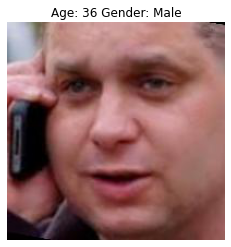

In [17]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

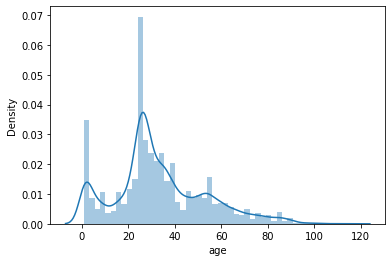

In [18]:
sns.distplot(df['age'])


In [19]:
df['gender'].value_counts()

gender
0    12391
1    11317
Name: count, dtype: int64

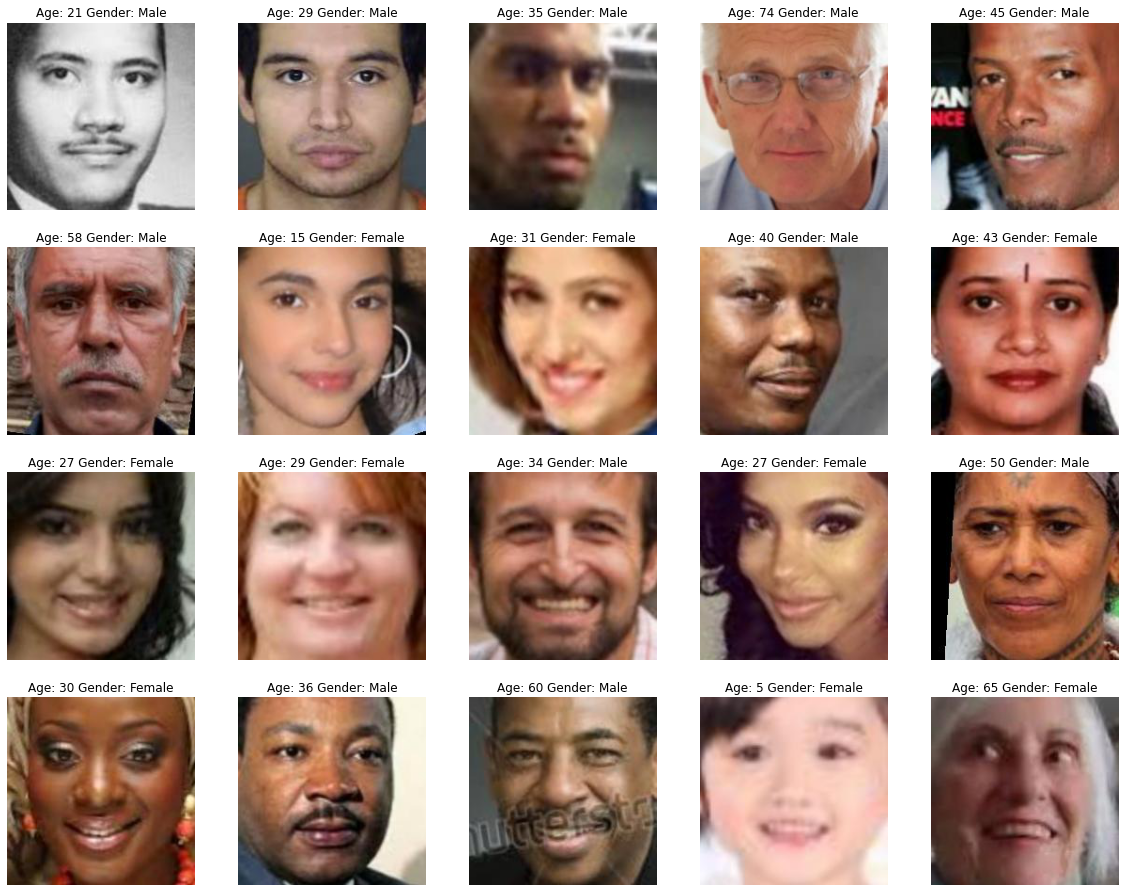

In [20]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:20]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(5, 5, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

In [21]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [22]:
X = extract_image_features(df['image_path'])

In [23]:
X.shape

(23708, 128, 128, 1)

In [24]:
X = X / 255.0

In [25]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [26]:
input_shape = (128, 128, 1)

In [27]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])


In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
593/593 [==============================] - 182s 305ms/step - loss: 15.8006 - gender_out_loss: 0.6752 - age_out_loss: 15.1253 - gender_out_accuracy: 0.5564 - age_out_accuracy: 0.0476 - val_loss: 12.2521 - val_gender_out_loss: 0.5122 - val_age_out_loss: 11.7399 - val_gender_out_accuracy: 0.7404 - val_age_out_accuracy: 0.0453
Epoch 2/50
593/593 [==============================] - 183s 309ms/step - loss: 11.6793 - gender_out_loss: 0.4865 - age_out_loss: 11.1928 - gender_out_accuracy: 0.7657 - age_out_accuracy: 0.0362 - val_loss: 11.2746 - val_gender_out_loss: 0.4300 - val_age_out_loss: 10.8446 - val_gender_out_accuracy: 0.7916 - val_age_out_accuracy: 0.0177
Epoch 3/50
593/593 [==============================] - 184s 311ms/step - loss: 10.2582 - gender_out_loss: 0.4255 - age_out_loss: 9.8327 - gender_out_accuracy: 0.8020 - age_out_accuracy: 0.0221 - val_loss: 8.8546 - val_gender_out_loss: 0.3840 - val_age_out_loss: 8.4707 - val_gender_out_accuracy: 0.8332 - val_age_out_accuracy: 0.

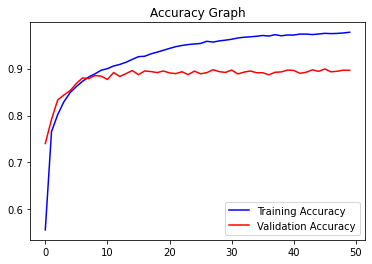

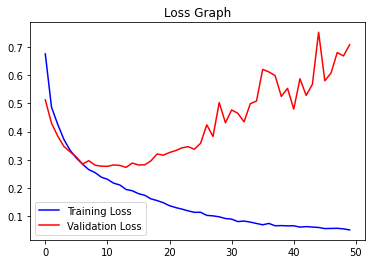

In [31]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

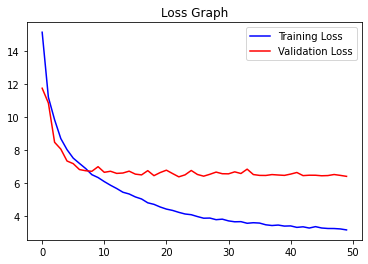

In [32]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [35]:
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

1/1 [==============================] - 0s 215ms/step


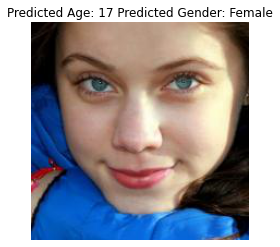

In [36]:
img_to_test = '/Users/harjeetchahal/Downloads/archive (2)/crop_part1/16_1_0_20170109212959831.jpg.chip.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))

In [37]:
BASE_DIR_1 = '/Users/harjeetchahal/Downloads/archive (2)/crop_part1'
age_labels_1 = []
gender_labels_1 = []
image_paths_1 = []

image_filenames_1 = os.listdir(BASE_DIR_1)
random.shuffle(image_filenames_1)

for image in tqdm(image_filenames_1):
  image_path_1 = os.path.join(BASE_DIR_1, image)
  img_components_1 = image.split('_')
  age_label_1 = int(img_components_1[0])
  gender_label_1 = int(img_components_1[1])

  # Append the image_path, age_label, and gender_label
  age_labels_1.append(age_label_1)
  gender_labels_1.append(gender_label_1)
  image_paths_1.append(image_path_1)

In [38]:
age_labels_1[:5]

[37, 26, 56, 40, 24]

37
0


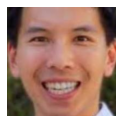

26
0


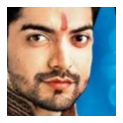

56
0


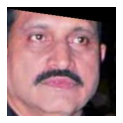

40
1


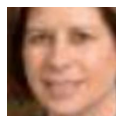

24
1


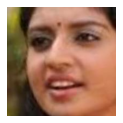

16
0


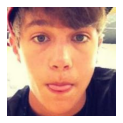

29
1


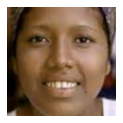

71
1


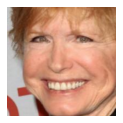

8
0


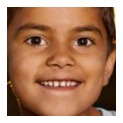

49
1


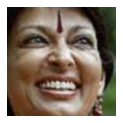

In [39]:
import cv2
import matplotlib.pyplot as plt

# Load and display the first 10 images
for i in range(10):
    image_path_1 = image_paths_1[i]
    image = cv2.imread(image_path_1)

    # Display the image using Matplotlib
    plt.figure(figsize=(2, 2))
    print(age_labels_1[i])
    print(gender_labels_1[i])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [40]:
image_paths_1[0]

'/Users/harjeetchahal/Downloads/archive (2)/crop_part1/37_0_2_20170105163305795.jpg.chip.jpg'

1/1 [==============================] - 0s 19ms/step
Actual Age: 37 Actual Gender: 0


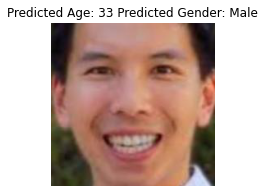

1/1 [==============================] - 0s 17ms/step
Actual Age: 26 Actual Gender: 0


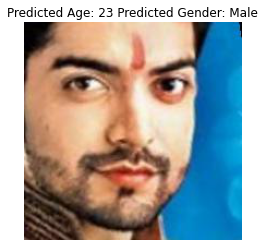

1/1 [==============================] - 0s 16ms/step
Actual Age: 56 Actual Gender: 0


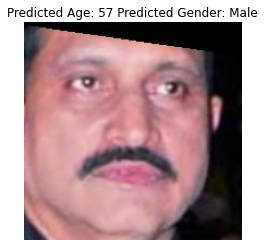

1/1 [==============================] - 0s 17ms/step
Actual Age: 40 Actual Gender: 1


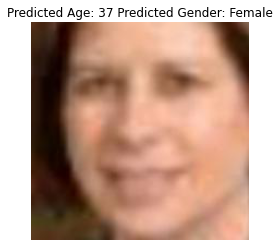

1/1 [==============================] - 0s 16ms/step
Actual Age: 24 Actual Gender: 1


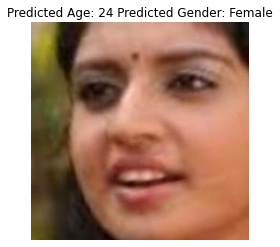

1/1 [==============================] - 0s 17ms/step
Actual Age: 16 Actual Gender: 0


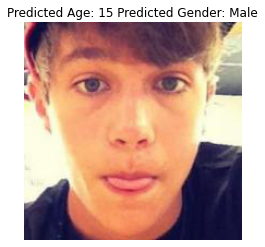

1/1 [==============================] - 0s 19ms/step
Actual Age: 29 Actual Gender: 1


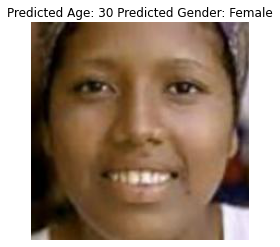

1/1 [==============================] - 0s 17ms/step
Actual Age: 71 Actual Gender: 1


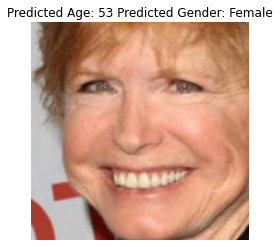

1/1 [==============================] - 0s 17ms/step
Actual Age: 8 Actual Gender: 0


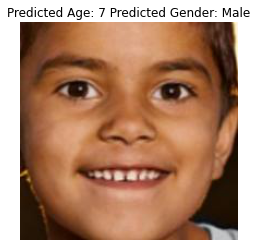

1/1 [==============================] - 0s 18ms/step
Actual Age: 49 Actual Gender: 1


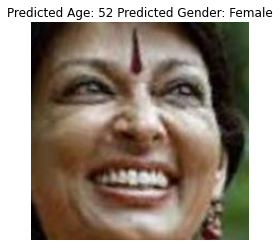

In [41]:
plt.figure(figsize=(3,3))
for i in range(10):
    img_to_test = image_paths_1[i]  # Use the current index 'i' to select a different image
    plt.imshow(np.array(load_img(img_to_test)))
    features = get_image_features(img_to_test)
    pred = model.predict(features)
    gender = gender_mapping[round(pred[0][0][0])]
    age = round(pred[1][0][0])

    plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
    print(f'Actual Age: {age_labels_1[i]} Actual Gender: {gender_labels_1[i]}')
    plt.axis('off')
    plt.show()